# OpenCV를 이용한 명함인식 구현 Tutorial - vol2
[Tutorial - vol01](https://github.com/ExcelsiorCJH/Projects/blob/master/Name%20Card%20Recognition/tutorial-vol1.ipynb)에서 공부한 내용을 토대로 저장된 명함 이미지에 대한 인식기 구현 튜토리얼

In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# load the image and compute the ratio of the old height
# to the new height, clone it, and resize it
# document.jpg ~ docuemnt7.jpg

image = cv2.imread('images/document2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
orig = image.copy()
r = 800.0 / image.shape[0]
dim = (int(image.shape[1] * r), 800)
image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

## STEP 1 : Edge Detection

STEP 1: Edge Detection


Text(0.5,1,'Edged')

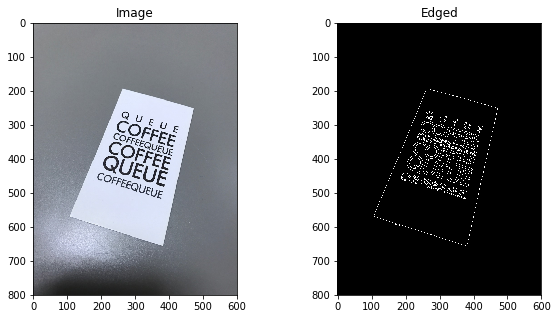

In [3]:
# convert the image to grayscale, blur it, and find edges
# in the image

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (3, 3), 0)
edged = cv2.Canny(gray, 75, 200)

# show the original image and the edge detected image
print("STEP 1: Edge Detection")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image)
axs[0].set_title('Image')
axs[1].imshow(edged, cmap='Greys_r')
axs[1].set_title('Edged')

# cv2.imshow() 를 이용해 plotting 하기
# cv2.imshow('edged', edged)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# cv2.waitKey(1)

## STEP 2: Find Contours of Paper

STEP 2: Find contours of paper


Text(0.5,1,'Outline')

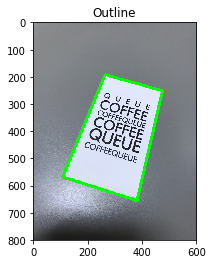

In [4]:
# find the contours in the edged image, keeping only the
# largest ones, and initialize the screen contour
_, cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]

# loop over the contours
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    
    # if our approximated contour has four points, then we
    # can assume that we have found our screen
    if len(approx) == 4:
        screenCnt = approx
        break
        
# show the contour (outline) of the piece of paper
print("STEP 2: Find contours of paper")
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 10)
plt.imshow(image)
plt.title("Outline")

## STEP 3: Apply Perspective Transform

![](./images/order_points.png)

STEP 3: Apply perspective transform


Text(0.5,1,'Warped')

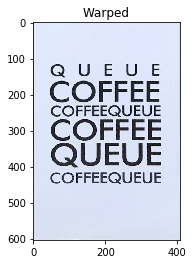

In [5]:
# apply the four point transform to obtain a top-down
# vidw of the original image

def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

rect = order_points(screenCnt.reshape(4, 2) / r)
topLeft, topRight, bottomRight, bottomLeft = rect

w1 = abs(bottomRight[0] - bottomLeft[0])
w2 = abs(topRight[0] - topLeft[0])
h1 = abs(topRight[1] - bottomRight[1])
h2 = abs(topLeft[1] - bottomLeft[1])
maxWidth = max([w1, w2])
maxHeight = max([h1, h2])

dst = np.float32([[0, 0], [maxWidth-1, 0],
                  [maxWidth-1, maxHeight-1], [0, maxHeight-1]])

M = cv2.getPerspectiveTransform(rect, dst)
warped = cv2.warpPerspective(orig, M, (maxWidth, maxHeight))

# show the original and scanned images
print("STEP 3: Apply perspective transform")
plt.imshow(warped)
plt.title('Warped')

## STEP 4: Apply Adaptive Threshold

STEP 4: Apply Adaptive Threshold


True

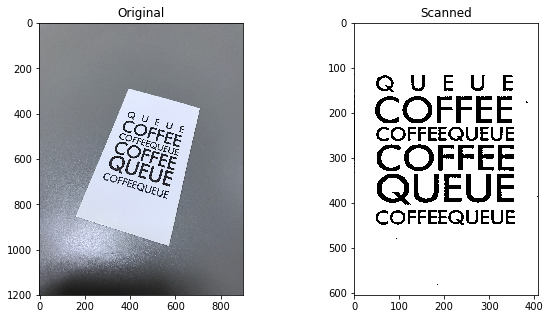

In [6]:
# convert the warped image to grayscale, then threshold it
# to give it that 'black and white' paper effect
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
warped = cv2.adaptiveThreshold(warped, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                               cv2.THRESH_BINARY, 21, 10)

print("STEP 4: Apply Adaptive Threshold")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(orig)
axs[0].set_title('Original')
axs[1].imshow(warped, cmap='Greys_r')
axs[1].set_title('Scanned')

cv2.imwrite('./images/scannedImage.png', warped)